In [1]:
"""
Realizado por: Lorena Perez - 20200396 :D

"""
# Librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse
import sys
import os

from time import time

# Modulos propios, se agregan las funciones utilizadas al script
# import cvlib
# import plot

# ------------------------------------------------

In [2]:
# Preparacion - Carga de funciones del modulo utilizado para este script.

In [3]:
# Funcion recopilada del modulo utilizado
def imgcdf(img):
    """Compute the CDF on an image
    Parameters: 
        img (numpy array): Source image
    Returns:
        cdf (list): Computed CDf of img
        hist (list): Histogram of img
    """
    hist_list = cv.calcHist([img],[0],None,[256],[0,256])
    hist = hist_list.ravel()

    cdf = []
    t = 0
    for p in hist:
        t += p
        cdf.append(t)
    return cdf, hist

def imgeq(img):
    """ Equalize a grayscale image
    Parameters:
        img (numpy array): Grayscale image to equalize
    Returns:
        eq (numpy array): Equalized image
    """
    cdf = imgcdf(img)[0]
    cdf_eq = []
    n = img.shape[0] * img.shape[1]
    m = min(i for i in cdf if i > 0)

    for i in cdf:
        if i >= m:
            cdf_eq.append(int(round(255*(i-m)/(n-m))))
        else:
            cdf_eq.append(0)
    eq = cv.LUT(img, np.array(cdf_eq).astype(np.uint8))
    return eq

In [4]:
# Funcion recopilada del modulo utilizado
def imgview(img, title=None, filename=None, axis=False, figsize=None):
    """
    imgview: funcion de visualizacion de imagen

    Parameters:
        img: matriz de la imagen a visualizar
        title: asignacion de titulo, por default no se coloca titulo
        filename: opcion para guardar la imagen, por default no se realiza la accion
        axis: visualizacion de los ejes, por default no se muestran
    """
    r,c = img.shape[0:2]
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    else:
        k = 8
        fig = plt.figure(figsize=(k,k))
    ax = fig.add_subplot(111)
    
    if len(img.shape) == 3:
        img = ax.imshow(img,extent=None)
    else:
        img = ax.imshow(img,extent=None,cmap='gray',vmin=0,vmax=255)
    if title != None:
        ax.set_title(title,fontsize=14)
    if not axis:
        plt.axis('off')
    else:
        ax.grid(c='w')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
        ax.set_xlabel('Columns',fontsize=14)
        ax.set_ylabel('Rows',fontsize=14)
        ax.xaxis.label.set_color('w')
        ax.yaxis.label.set_color('w')
        ax.tick_params(axis='x', colors='w',labelsize=14)
        ax.tick_params(axis='y', colors='w',labelsize=14)
        
    if filename != None:
        plt.savefig(filename)
    plt.show()

In [5]:
# Parte 1 - Funciones solicitadas

# imgpad: funcion de paddin de ceros.
# first_pass: primer recorrido de la imagen binaria para asignar la etiqueta.
# second_pass: segundo recorrido para la asignacion de la etiqueta, componente conectado.
# connected_c: funcion que utiliza otras funciones con el fin de etiquetar los componenetes conectados de una imagen binarizada
# labelview: imagen resultante con los labels diferenciados por color.

In [6]:
def imgpad(img, r):
    """
    Realiza un padding de ceros de r pixeles alrededor de una imagen binaria.
    Esta funcion toma una imagen (matriz) y agrega un marco de ceros alrededor
    de la misma. El ancho del borde esta definido por el valor 'r'.

    Parameters:
        img (np.uint8): Matriz NumPy que representa la imagen.
        r (int): Tamaño del borde de ceros que se agregara alrededor de la imagen.

    Returns:
        matriz (np.uint8): La imagen de entrada con un borde de ceros agregado alrededor.

    """

    # Agregando los marcos extremos de las filas
    matriz_row = np.zeros((r, img.shape[1])) 
    matriz = np.concatenate((matriz_row, img), axis = 0)
    matriz = np.concatenate((matriz, matriz_row), axis = 0)

    # Agregando los marcos extremos de las columnas
    matriz_col = np.zeros((matriz.shape[0], r))
    matriz = np.concatenate((matriz_col, matriz), axis = 1)
    matriz = np.concatenate((matriz, matriz_col), axis = 1)
    return matriz

In [7]:
def first_pass(img):
    """
    Itera por cada elemento por columna para etiquetar componentes conectados en una imagen binaria.

    Esta funcion toma una imagen binaria y realiza un primer recorrido para etiquetar
    componentes conectados. Devuelve una matriz de etiquetas y una lista de vecinos
    conectados.

    Parameters:
        img (np.uint8): Matriz NumPy que representa la imagen binaria.

    Returns:
        - etiq_array (np.uint8): Una matriz de etiquetas donde se etiquetan los componentes conectados.
        - vec_array (List): Una lista de pares de vecinos conectados.

    """

    init_img = imgpad(img, 1)
    r, c = init_img.shape
    # Inicializacion de la etiqueta
    etiqueta = 1

    etiq_array = np.zeros((r, c), dtype=int)
    vec_array = []

    for i in range(1, r - 1):
        for j in range(1, c - 1):
            if init_img[i][j] != 0:
                vecinos = [etiq_array[i - 1][j], etiq_array[i][j - 1]]
                if vecinos[0] != 0:
                    etiq_array[i][j] = vecinos[0]
                    if vecinos[1] != 0 and vecinos[0] != vecinos[1]:
                        vec_array.append(vecinos)
                elif vecinos[1] != 0:
                    etiq_array[i][j] = vecinos[1]
                else:
                    etiq_array[i][j] = etiqueta
                    etiqueta += 1
    
    return etiq_array, vec_array


In [8]:
def labels_result(labels_vec):
    """
    Elimina duplicados de una lista de tuplas.

    Esta funcion toma una lista de tuplas y elimina cualquier tupla duplicada,
    manteniendo el orden original de las tuplas.

    Parameters:
        labels_vec (list): Lista de tuplas de entrada.

    Returns:
        unique_labels_vec (list): Una lista que contiene las tuplas unicas, sin duplicados.

    """
    unique_labels_vec = list({tuple(item) for item in labels_vec})
    return unique_labels_vec


In [9]:
def replace_vec(labels_vec, numero):
    """
    Reemplaza etiquetas en un conjunto de etiquetas vecinas.

    Parameters:
        labels_vec (list): Lista de pares de etiquetas conectadas.
        numero (int): Etiqueta inicial a reemplazar.

    Returns:
        int: Etiqueta minima de la componente conexa resultante.
    """
    labels_set = {}
    for a, b in labels_vec:
        if a in labels_set:
            labels_set[a].append(b)
        else:
            labels_set[a] = [b]
        if b in labels_set:
            labels_set[b].append(a)
        else:
            labels_set[b] = [a]

    visitados = set()
    labels_c = [numero]

    while labels_c:
        actual = labels_c.pop(0)
        visitados.add(actual)
        labels_c.extend(label for label in labels_set.get(actual, []) if label not in visitados)

    return min(visitados, default=numero)


In [10]:
def second_pass(labels_img, labels_vec):
    """
    Realiza el segundo recorrido del algoritmo de etiquetado, reemplazando etiquetas en la imagen.

    Parameters:
        labels_img (np.uint8): Matriz de etiquetas de la imagen.
        labels_vec (list): Lista de pares de etiquetas conectadas.

    Returns:
        labels_img (np.unit8): Matriz de etiquetas de la imagen con etiquetas reemplazadas.
    """
    r, c = labels_img.shape
    replace_dict = {}
    progreso = 0

    for i in range(r):
        for j in range(c):
            if labels_img[i][j] != 0:
                if labels_img[i][j] in replace_dict:
                    labels_img[i][j] = replace_dict[labels_img[i][j]]
                else:
                    replace_etiq = replace_vec(labels_vec, labels_img[i][j])
                    if replace_etiq is not None:
                        labels_img[i][j] = replace_etiq
                        replace_dict[labels_img[i][j]] = replace_etiq
            progreso += 1
            porcentaje = (progreso / (r * c)) * 100
            if porcentaje % 10 == 0:
                print(f"\t: {porcentaje:.0f}%") # Solo para fines de visualizacion del proceso
    return labels_img


In [11]:
def connected_c(img):
    """
    Realiza la segmentacion de componentes conectados en una imagen.

    Parameters:
        img (np.uint8): Imagen de entrada.

    Returns:
        result_img (np.uint8): Imagen segmentada con etiquetas de componentes conectados.
    """
    labels_img, labels_vec = first_pass(img)
    labels_vec = labels_result(labels_vec)
    result_img = second_pass(labels_img, labels_vec)
    return result_img

In [12]:
def random_color():
    """
    Genera un color aleatorio brillante y distintivo.

    Returns:
        Tuple: Una tupla (R, G, B) que representa un color RGB aleatorio.
    """
    return (np.random.randint(50, 256), np.random.randint(50, 256), np.random.randint(50, 256))

def labelview(labels, name_save=None):
    """
    Muestra una imagen etiquetada con colores aleatorios para cada componente conectado.

    Parameters:
        imagen (np.uint8): Imagen original.
        labels (np.uint8): Matriz de etiquetas de componentes conectado.
        name_save (str): Nombre de la imagen para guardar.

    Returns:
        None
    """
    unique_labels = np.unique(labels)
    colored_image = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

    for label in unique_labels:
        if label == 0:
            continue
        mask = (labels == label)
        color = random_color()
        colored_image[mask] = color

    imgview(colored_image, "Output", filename=name_save)


In [13]:
# Codigo de prueba para imagenes random de testing

# array = np.random.randint(2, size=(220, 220))
# array = array.astype(np.uint8)

# result = connected_c(array)
# labelview(result)

# ultimo time de prueba
# time 1m.36s
# time 44s

In [14]:
# Parte 2 - Procesamiento de la imagen. 

In [15]:
""" 
Parameters:
    name_image: Nombre de la imagen de lectura para el procesamiento.
    imgray (np.uint8): Lectura de la imagen a procesar. Aplica la lectura de la imagen en escala de grises.
    img_eq (np.unit8): Realiza una ecualizacion de histograma en la imagen para mejorar su contraste.
"""
#imgray = cv.imread(PATH+'/'+name_image, cv.IMREAD_GRAYSCALE)
imgray = cv.imread('fprint3.pgm', cv.IMREAD_GRAYSCALE)
img_eq = imgeq(imgray)

# Aplica un umbral en la imagen para obtener una imagen binarizada con el valor
# de umbral de 115, utilizando el metodo de truncamiento (THRESH_TRUNC) con el fin de eliminar
# el ruido del fondo de la imagen.
_, imgray = cv.threshold(img_eq, 115, 255,cv.THRESH_TRUNC)

In [16]:
"""
Aplica la operación de relleno (flood fill) en una imagen en escala de grises.
"""

D = 35 #Umbral de diferencia de intensidad de color.
imgray_f = imgray.copy()
cv.floodFill(imgray_f, None, (1,10), 140,  loDiff=D, upDiff=D, flags=cv.FLOODFILL_FIXED_RANGE)
imgray = imgray_f

In [17]:
"""
Aplica una serie de operaciones de procesamiento de imagenes para obtener contornos.

Parameters:
    - k (int): Tamaño del kernel para el blur.
    - img_blur (np.uint8): Imagen suavizada despues de aplicar el filtro.
    - imgbin (np.uint8): Imagen binarizada resultante de la umbralizacion adaptativa.
    - contours (list): Lista de contornos detectados en la imagen.
    - hierarchy (numpy.ndarray): Jerarquia de contornos.
"""

k = 5
img_blur = cv.GaussianBlur(imgray,(k,k),3)
cv.normalize(img_blur, img_blur, 30, 110, cv.NORM_MINMAX)
imgbin = cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 13,3)
mode = cv.RETR_TREE
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE]
contours, hierarchy = cv.findContours(imgbin, mode, method[1])

In [18]:
"""
Aplica una serie de operaciones para filtrar y refinar contornos en una imagen binarizada.

Parameters:
    - area_min (int): Area minima para mantener un contorno.
    - mask (np.uint8): Mascara de contornos filtrados.
    - area_maxima (int): Area maxima para refinar los contornos.
    - result_img (np.uint8): Imagen resultante despues de refinar los contornos
        y aplicar todos los cambios.
"""

area_min = 10
mask = np.zeros_like(imgbin)

for contour in contours:
    if cv.contourArea(contour) == 8 or cv.contourArea(contour) > area_min:
        cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)

result_img = cv.bitwise_and(imgbin, mask)
contornos, _ = cv.findContours(result_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
percent = 0.01
area_maxima = 340

for cnt in contornos:
    area = cv.contourArea(cnt)
    if area <= area_maxima:
        epsilon = percent * cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, epsilon, True)
        cv.fillPoly(result_img, [approx], 255)

	: 10%
	: 20%
	: 30%
	: 40%
	: 50%
	: 60%
	: 70%
	: 80%
	: 90%
	: 100%

 -----------------------------
Executed in 4.89 min. 



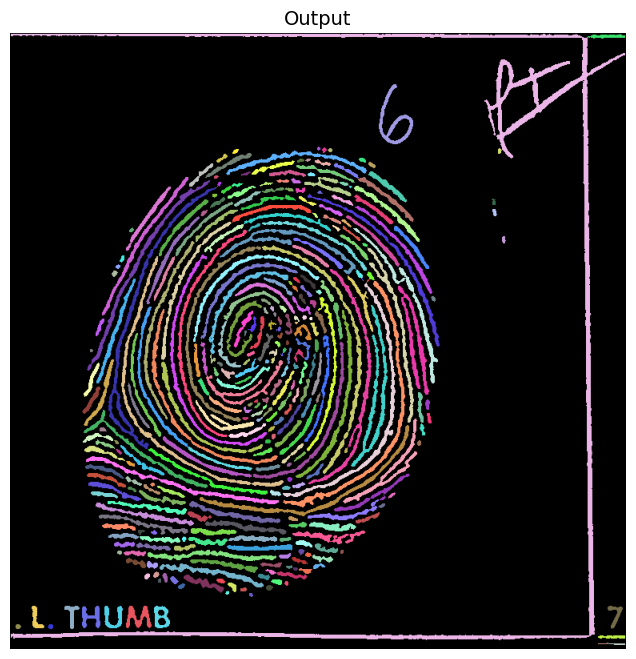

In [19]:
"""
Encuentro los componentes conectados de una imagen tratada. Utiliza la variante two-pass del
algoritmo Connected Componet labeling (CCL).

Parameters:
    - name_save (str): Nombre de la salida de la imagen a guardar.
    - result (np.uint8): Resultado de la imagen al procesarla con la funcion connected_c.


Return:
    - labelview(result, name_save): Devuelve la imagen con los colores de cada etiqueta.
"""

# Measure exec time
start_time = time()
result = connected_c(result_img)
print('\n -----------------------------')
print(f'Executed in {(time()- start_time)/60:.2f} min. \n') # Con el fin de ver cuanto tiempo se tarda.
labelview(result)

# tiempo promedio 4 minutos

In [20]:
# ------------------------------------------------ FIN :D